<a href="https://colab.research.google.com/github/Viraj-Rana008/ML-Algorithms/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from numpy.random import rand
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
diabetes_data = pd.read_csv("/content/diabetes.csv")

In [ ]:
diabetes_data.shape

(768, 9)

In [ ]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


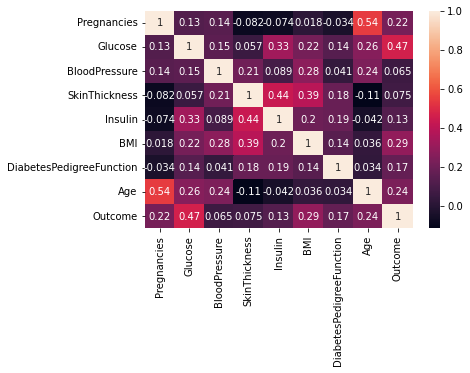

In [ ]:
sns.heatmap(diabetes_data.corr(), annot=True)
plt.show()

Splliting Data into Training and Validation and Test

In [ ]:
training_set        = diabetes_data.sample(frac=0.7, replace=False, random_state=0, axis=0)
validation_and_test = diabetes_data.drop(training_set.index) 

validation_set      = validation_and_test.sample(frac=0.66, replace=False, random_state=0, axis=0)
test_set            = validation_and_test.drop(validation_set.index)


# Seperating features
X_train = training_set.drop(['Outcome'], axis=1)
X_valid = validation_set.drop(['Outcome'], axis=1)
X_test  = test_set.drop(['Outcome'], axis=1)

# Seperating Label
Y_train = training_set['Outcome']
Y_valid = validation_set['Outcome']
Y_test  = test_set['Outcome']

Logistic Regression Modal Class

In [3]:
class LogisticRegression():
  def __init__(self, learning_rate, epochs, threshold, normalise=False):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.threshold = threshold
    self.normalise = normalise

    self.train_loss = []
    self.train_accuracy = []
    self.valid_loss = []
    self.valid_accuracy = []
  
  def fit(self, X_train, Y_train, X_valid, Y_valid):

    self.num_samples, self.num_features = X_train.shape

    self.X_train = X_train.copy()
    self.X_valid = X_valid.copy()

    # Gaussian Normalisation
    if self.normalise:             
      mean    = X_train.mean()
      std_dev = X_train.std()
      self.X_train  = (self.X_train - mean) / std_dev
    
      mean    = X_valid.mean()
      std_dev = X_valid.std()
      self.X_valid = (self.X_valid - mean) / std_dev

    
    # add Bias as feature
    self.X_train['bias'] = np.ones(len(X_train))
    self.X_valid['bias'] = np.ones(len(X_valid))

    # Num of weighs = num_of_feature + bias
    self.weights   = np.zeros(self.num_features+1)



    for _ in range(self.epochs):
      
      # set traininf loss & accuracy
      self.train_loss.append( self.loss(self.sigmoid(self.X_train), Y_train) )    
      self.train_accuracy.append( self.accuracy(self.predict(self.X_train, False), Y_train) )

      # set validation loss & accuracy
      self.valid_loss.append(self.loss(self.sigmoid(self.X_valid), Y_valid))
      self.valid_accuracy.append(self.accuracy(self.predict(self.X_valid, False), Y_valid))

      y_pred = self.sigmoid(self.X_train)

      #gradient
      dW = np.dot(self.X_train.T, y_pred - Y_train) / self.num_samples

      # descent
      self.weights = self.weights - self.learning_rate * dW
    
    return

  
  def loss(self, Y_pred, Y_desired):
    predict_1 = Y_desired * np.log(Y_pred)             # Cost for Y=1

    predict_0 = (1 - Y_desired) * np.log(1 - Y_pred)   # Cost for Y=0

    total_loss = - sum(predict_1 + predict_0) / len(Y_desired)

    return total_loss


  def sigmoid(self, X):
    '''
      Takes input features, returns predicted values in range (0,1)
    '''
    Z = X.dot(self.weights)
    return 1 / (1 + np.e**(-Z))

  def accuracy(self, y_pred, y_desired):
    correct = 0
    i = 0

    for val in y_desired:
      if y_pred[i] == val:
        correct+=1
      i+=1
    
    return (correct / float(len(y_desired))) * 100


  def predict(self, X, normalise=True):
    X_t = X.copy()

    if normalise and self.normalise:
      mean    = X.mean()
      std     = X.std()
      X_t     =  (X_t - mean) / std
    
      X_t['bias'] = np.ones(len(X))

    Y = self.sigmoid(X_t)
    predictions = np.where(Y>self.threshold, 1, 0)
    return predictions


KFold Validation Class
- reset_index(drop=True) : Drop previously existing row indices

In [16]:
class KFold:
  def __init__(self, n_split=5, shuffle=False, random_state=1):
    self.n_split = n_split
    self.shuffle = shuffle
    self.random_state = random_state
  
  def split(self, data):
    if self.shuffle:
      X = data.sample(frac=1, replace=False, random_state=self.random_state, axis=0)
    
    # size of one fold window
    wnd = X.shape[0] // self.n_split

    startInd = 0
    folds = []
    for i in range(self.n_split) :
      endInd = startInd + wnd 

      test_set = X.iloc[startInd : endInd].copy().reset_index(drop=True)
      
      frames   = [ X.iloc[0 : startInd].copy(), X.iloc[endInd : ].copy() ]
      train_set  = pd.concat(frames).reset_index(drop=True)

      folds.append((train_set, test_set))
      
      startInd = endInd
    
    return folds


[65.3658536585366, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.79674796747967, 74.79674796747967, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.796747967

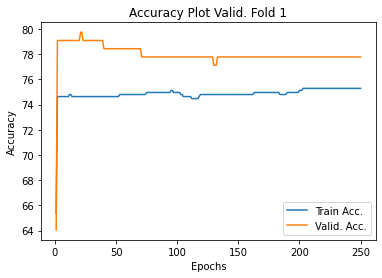

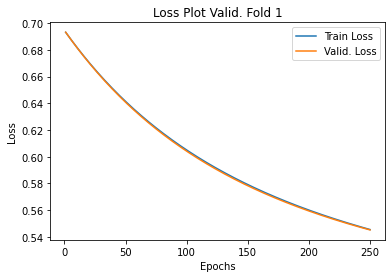

[65.04065040650406, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.60975609756098, 75.60975609756098, 75.60975609756098, 75.60975609756098, 75.77235772357723, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.60975609756098, 75.60975609756098, 75.60975609756098, 75.60975609756098, 75.60975609756098, 75.60975609756098, 75.60975609756098, 75.6097560975

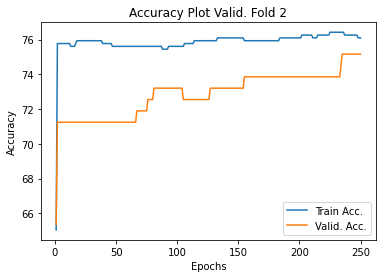

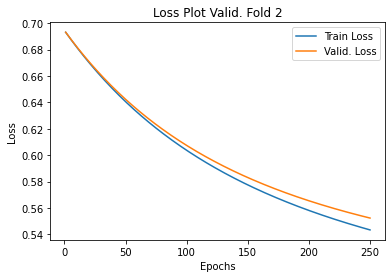

[65.20325203252033, 75.1219512195122, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.28455284552845, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.44715447154472, 75.60975609756098, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.77235772357723, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935, 75.9349593495935,

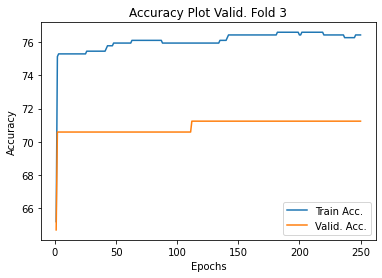

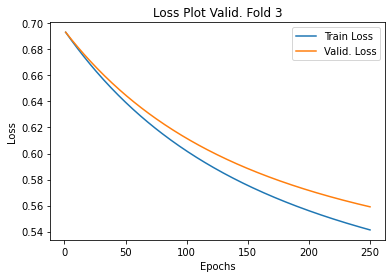

[64.39024390243902, 74.47154471544715, 74.47154471544715, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796

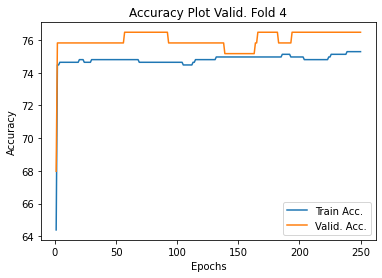

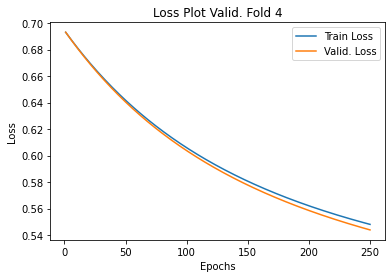

[65.20325203252033, 73.98373983739837, 73.98373983739837, 73.98373983739837, 73.98373983739837, 73.98373983739837, 73.98373983739837, 73.98373983739837, 73.98373983739837, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.30894308943088, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.14634146341463, 74.30894308943088, 74.30894308943088, 74.47154471544715, 74.47154471544715, 74.47154471544715, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634146342, 74.63414634

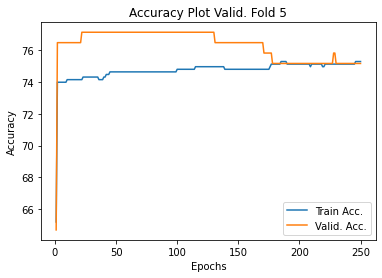

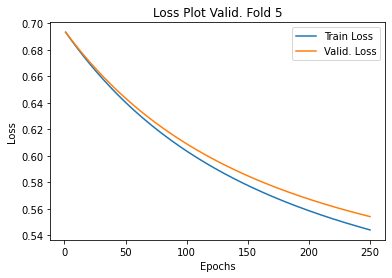

In [17]:
kf = KFold(shuffle=True)
fold = 1
for train_set, test_set in kf.split(diabetes_data):
  logi = LogisticRegression(learning_rate=0.01, epochs=250, threshold=0.5, normalise=True)

  x_train = train_set.drop(['Outcome'], axis=1)
  x_test  = test_set.drop(['Outcome'], axis=1)

  y_train = train_set['Outcome']
  y_test  = test_set['Outcome']

  logi.fit(x_train, y_train, x_test, y_test)


  plot = np.arange(1, logi.epochs+1)
  plt.plot(plot, logi.train_accuracy, label='Train Acc.')
  plt.plot(plot, logi.valid_accuracy, label='Valid. Acc.')
  plt.title(f'Accuracy Plot Valid. Fold {fold}')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plot = np.arange(1, logi.epochs+1)
  plt.plot(plot, logi.train_loss, label='Train Loss')
  plt.plot(plot, logi.valid_loss, label='Valid. Loss')
  plt.title(f'Loss Plot Valid. Fold {fold}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  fold+=1